# Anaysis pipeline of _D. novamexicana_ post-mating RNAseq 

#### Load required packages

In [1]:
## Define required packages
req_packages = c("Biobase", "cluster", "cowplot", "cummeRbund", "data.table", "DESeq", "edgeR", "ggplot2", "ggrepel", "ggthemes", "GO.db", "goseq", "grid", "gridExtra", "plotly", "qvalue", "reshape", "Rmisc", "splitstackshape", "statmod", "VennDiagram", "ggthemr")

## Load them
lapply(req_packages, require, character.only = TRUE)

## Set ggplot's theme back to defaults (cowplot changes it)
theme_set(theme_gray())

## Load heatmap script and miscellaneous R functions (From the Trinity package)
source("~/Dropbox/RNAseq/Male_RNAseq/VirilisGroupMaleRNAseq.Rproject/R.functions/heatmap.3.R")
source("~/Dropbox/RNAseq/Male_RNAseq/VirilisGroupMaleRNAseq.Rproject/R.functions/misc_rnaseq_funcs.R")

### Here're several convenient plotting functions:

## MA plots between two columns of a matrix. Also calculates the proportion of genes that are >2-fold against the logCount.
MA_BPlot <- function(data, col1, col2) {
    arguments <- as.list(match.call())
    y = eval(as.name(arguments$col2), data)
    x = eval(as.name(arguments$col1), data)
    M = log2(x/y)
    A = 0.5*log2(x*y);
    res = data.frame(row.names(data),x=M, y=A, row.names = 1)
    res$bins <- cut(x=res$y, breaks=seq(from=0, to=20, by = 0.5), labels=as.character(seq(0.5,20,0.5)))
    res$count = 1
    bad.res = subset(res, x >= 1 | x <= -1)
    bad.res = subset(bad.res, x != Inf & x != (-Inf))
    badBygroup = tapply(bad.res$count, bad.res$bins, sum)
    allBygroup = tapply(res$count, res$bins, sum)
    off.2fold = badBygroup/allBygroup
    off.2fold = data.frame(off.2fold)
    off.2fold <- cbind(log2Bin = row.names(off.2fold), off.2fold)
    rownames(off.2fold) <- NULL
    off.2fold$log2Bin <- factor(off.2fold$log2Bin, levels=as.character(seq(0.5,20,0.5)))
    b.plot <- ggplot(off.2fold, aes(log2Bin, off.2fold)) + geom_bar(stat = "identity", fill="#F8766D", colour = "#00BFC4") + labs(y="prop. >2-fold", x="log2 read count bin") + theme(legend.position="none") + labs(title = paste(col1, "vs", col2, sep = " "), face = "bold")
    res$FC = NA
    res$FC[res$x > 1 ] = "above" 
    res$FC[res$x < -1 ] = "above"
    ma.plot = ggplot(res, aes(y, x, colour = FC)) + geom_point() + labs(y = "M [log2(x/y)]", x = "A [0.5xlog2(xy)]")+ scale_x_continuous(limits=c(0,20)) + theme(legend.position="none")
    #ma.plot = qplot(y, x, data = res, colour = FC, ylab = "M [log2(x/y)]", xlab = "A [0.5xlog2(xy)]") + scale_x_continuous(limits=c(0,20)) + theme(legend.position="none")
    plots = plot_grid(b.plot, ma.plot, ncol = 1)
    return(plots)
}
#
plotGenePM<-function(object, gene_id, logMode=FALSE){
  if (grepl("FBgn", gene_id)){
    geneName<-subset(Annots, FBgn_ID == gene_id)$gene_name
  } else {geneName<-subset(Annots, gene_name == gene_id)$FBgn_ID}
  swisprotName<-subset(Annots, FBgn_ID == gene_id | gene_name == gene_id)$SwissProt_BlastX_Description
  melOrth<-subset(Annots, FBgn_ID == gene_id | gene_name == gene_id)$mel_GeneSymbol
  omega<-subset(paml.data, FBgn_ID == gene_id | gene_name == gene_id)$omega
  coords.tmp<-subset(gffRecord, FBgn_ID == gene_id | gene_name == gene_id)
  coords<-paste(coords.tmp$chromosome, ":", coords.tmp$min,"-",coords.tmp$max, sep = "")
  p <- ggplot(subset(object, FBgn_ID == gene_id | gene_name == gene_id), aes(time, TPM, fill = condition)) + geom_bar(position=position_dodge(), stat="identity") + geom_errorbar(aes(ymin=TPM-se, ymax=TPM+se), width=.2, position=position_dodge(.9)) + facet_grid(~tissue, scales="free_x", space = "free_x") + labs(title = paste(gene_id," (", geneName,"), ",coords,"\n","Ka/Ks = ", omega,"        mel. orth.: ",melOrth,"\n",swisprotName, sep = "")) + scale_fill_manual(values = c("#77756b", "#b067a3", "#9c954d"))
  if (logMode)
  {
    p <- p + scale_y_log10()
  }
  if (logMode)
  {
    p <- p + ylab("log10 TPM")
  } else {
    p <- p + ylab("TPM")
  }
  return(p)
}
#
plotGenePM_RT<-function(object, gene_id, logMode=FALSE){
  if (grepl("FBgn", gene_id)){
    geneName<-subset(Annots, FBgn_ID == gene_id)$gene_name
  } else {geneName<-subset(Annots, gene_name == gene_id)$FBgn_ID}
  swisprotName<-subset(Annots, FBgn_ID == gene_id | gene_name == gene_id)$SwissProt_BlastX_Description
  melOrth<-subset(Annots, FBgn_ID == gene_id | gene_name == gene_id)$mel_GeneSymbol
  omega<-subset(paml.data, FBgn_ID == gene_id | gene_name == gene_id)$omega
  coords.tmp<-subset(gffRecord, FBgn_ID == gene_id | gene_name == gene_id)
  coords<-paste(coords.tmp$chromosome, ":", coords.tmp$min,"-",coords.tmp$max, sep = "")
  p <- ggplot(subset(object, FBgn_ID == gene_id & tissue == "RT"| gene_name == gene_id & tissue == "RT"), aes(time, TPM, fill = condition)) + geom_bar(position=position_dodge(), stat="identity") + geom_errorbar(aes(ymin=TPM-se, ymax=TPM+se), width=.2, position=position_dodge(.9)) + labs(title = paste(gene_id," (", geneName,"), ",coords,"\n","Ka/Ks = ", omega,"        mel. orth.: ",melOrth,"\n",swisprotName, sep = "")) + scale_fill_manual(values = c("#77756b", "#b067a3", "#9c954d"))
  if (logMode)
  {
    p <- p + scale_y_log10()
  }
  if (logMode)
  {
    p <- p + ylab("log10 TPM")
  } else {
    p <- p + ylab("TPM")
  }
  return(p)
}
# Plot mel gene
plotGeneMel<-function(object, gene_id, logMode=FALSE){
    if (grepl("FBgn", gene_id)){
        geneName<-subset(object, mel_FBgn_ID == gene_id)$mel_GeneSymbol
    } else {geneName<-subset(object, mel_GeneSymbol == gene_id)$mel_FBgn_ID}
    p <- ggplot(subset(object, mel_FBgn_ID == gene_id | mel_GeneSymbol == gene_id), aes(tissue, as.numeric(RPKM), fill = status)) + 
        geom_bar(stat = "identity", position = "dodge") + 
        facet_grid(age~sex, scales = "free") + 
        theme(axis.text.x=element_text(angle=45, vjust = 0.1)) + 
        labs(title = paste(gene_id,", ", geneName, sep = ""))
    if (logMode)
    {
        p <- p + scale_y_log10()
    }
    if (logMode)
    {
        p <- p + ylab("log10 RPKM")
    } else {
        p <- p + ylab("RPKM")
    }
    return(p)
}

## Heatmap plotter (based on cummerBund's heatmap function)
plotHeatmap <- function (object, rescaling = "row", clustering = "row", labCol = T, labRow = F, logMode = T, pseudocount = 1, border = FALSE, heatscale = c(low = "blue", mid = "black", high = "yellow"), heatMidpoint = NULL, method = "none", fullnames = T, replicates = FALSE, ...) {  
    
    m = object
    m = m[!apply(m, 1, sum) == 0, ]
    if (logMode) {
        m = log2(m + pseudocount)
    }
    
    if (!is.function(method)) {
        method = function(mat) {
            JSdist(makeprobs(t(mat)))
        }
    }
    if (clustering == "row") {
        m = m[hclust(method(m))$order, ]
    }
    if (clustering == "column") {
        m = m[, hclust(method(t(m)))$order]
    }
    if (clustering == "both") {
        m = m[hclust(method(m))$order, hclust(method(t(m)))$order]
    }
    if (is.function(rescaling)) {
        m = rescaling(m)
    } else {
        if (rescaling == "column") {
            m = scale(m, center = T)
            m[is.nan(m)] = 0
        }
        if (rescaling == "row") {
            m = t(scale(t(m), center = T))
            m[is.nan(m)] = 0
        }
    }
    rows = dim(m)[1]
    cols = dim(m)[2]
    melt.m = cbind(rowInd = rep(1:rows, times = cols), colInd = rep(1:cols, each = rows), melt(m))
    g = ggplot(data = melt.m)
    if (border == TRUE) 
        g2 = g + geom_rect(aes(xmin = colInd - 1, xmax = colInd, 
                               ymin = rowInd - 1, ymax = rowInd, fill = value), 
                           colour = "grey")
    if (border == FALSE) 
        g2 = g + geom_rect(aes(xmin = colInd - 1, xmax = colInd, 
                               ymin = rowInd - 1, ymax = rowInd, fill = value))
    if (labCol == T) {
        g2 = g2 + scale_x_continuous(breaks = (1:cols) - 
                                         0.5, labels = colnames(m))
    }
    if (labCol == F) {
        g2 = g2 + scale_x_continuous(breaks = (1:cols) - 
                                         0.5, labels = rep("", cols))
    }
    if (labRow == T) {
        g2 = g2 + scale_y_continuous(breaks = (1:rows) - 
                                         0.5, labels = rownames(m))
    }
    if (labRow == F) {
        g2 = g2 + scale_y_continuous(breaks = (1:rows) - 
                                         0.5, labels = rep("", rows))
    }
    g2 <- g2 + theme(axis.ticks = element_blank())
    g2 = g2 + theme(panel.grid.minor = element_line(colour = NA), 
                    panel.grid.major = element_line(colour = NA), panel.background = element_rect(fill = NA, 
                                                                                                  colour = NA))
    g2 = g2 + theme(axis.text.x = element_text(angle = -90, 
                                               hjust = 0))
    if (logMode & rescaling == "row") {
        legendTitle <- bquote(paste("centered ", log[2], " (TPM + ", 
                                    .(pseudocount), ")", sep = ""))
    }
    else if (logMode & rescaling == "none") {
        legendTitle <- bquote(paste(log[2], " (TPM + ", 
                                    .(pseudocount), ")",sep = ""))
    }
    else {
        legendTitle <- "TPM"
    }
    if (length(heatscale) == 2) {
        g2 <- g2 + scale_fill_gradient(low = heatscale[1], 
                                       high = heatscale[2], name = legendTitle)
    }
    else if (length(heatscale) == 3) {
        if (is.null(heatMidpoint)) {
            heatMidpoint = (max(m) + min(m))/2
        }
        g2 <- g2 + scale_fill_gradient2(low = heatscale[1], 
                                        mid = heatscale[2], high = heatscale[3], midpoint = heatMidpoint, 
                                        name = legendTitle)
    }
    return(g2)
}  

## A function to calculate the tissue specificity index (based on CummerBund's S function)
calcSpecificity<-function(matrix,logMode=T,pseudocount=1,relative=FALSE){
    tpms<-matrix
    if(logMode){
        tpms<-log10(tpms+pseudocount)
    }
    tpms<-t(makeprobs(t(tpms)))
    d<-diag(ncol(tpms))
    res<-apply(d,MARGIN=1,function(q){
        JSdistFromP(tpms,q)
    })
    colnames(res)<-paste(colnames(tpms))
    
    if(relative){
        res<-res/max(res)
    }
    1-res
}

## Lookup annotation information of a given gene (dvir1.06 data)
geneLookupG <- function(gene, complete=F) {
    if (complete){
        result <- noquote(t(subset(Annots, FBgn_ID == gene | gene_name == gene)))
        return (result)
    } else {
        result <- noquote(t(subset(Annots, FBgn_ID == gene | gene_name == gene, select = c(gene_name, FBgn_ID, FBtr_ID, chromosome, SwissProt_BlastX_Description, mel_GeneSymbol))))
    }
    return (result) 
}

## Modifications of functions to compare groups of lists 
## (from http://stackoverflow.com/questions/23559371/how-to-get-the-list-of-items-in-venn-diagram-in-r)
Intersect <- function (x) {  
    # Multiple set version of intersect
    # x is a list
    if (length(x) == 1) {
        unlist(x)
    } else if (length(x) == 2) {
        intersect(x[[1]], x[[2]])
    } else if (length(x) > 2){
        intersect(x[[1]], Intersect(x[-1]))
    }
}
#
Union <- function (x) {  
    # Multiple set version of union
    # x is a list
    if (length(x) == 1) {
        unlist(x)
    } else if (length(x) == 2) {
        union(x[[1]], x[[2]])
    } else if (length(x) > 2) {
        union(x[[1]], Union(x[-1]))
    }
}
#
Setdiff <- function (x, y) {
    # Remove the union of the y's from the common x's. 
    # x and y are lists of characters.
    xx <- Intersect(x)
    yy <- Union(y)
    setdiff(xx, yy)
}

## Ouput the color IDs used by ggplot
gg_color_hue <- function(n) {
    hues = seq(15, 375, length = n + 1)
    hcl(h = hues, l = 65, c = 100)[1:n]
}

## Miscellaneous operators
'%!in%' <- function(x,y)!('%in%'(x,y))




Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignette

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

[[22]]
[1] TRUE

### Read in expression data

In [2]:
DnovPM.dvir1.06.CountsMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.counts.matrix", header=T, row.names=1, com='', check.names=F)
DnovPM.dvir1.06.TpmMatrix.cbmt = read.table("ExpressionData/genes_DnovPM_dvi1.06.TPM.not_cross_norm.counts_by_min_TPM", header = T)
DnovPM.dvir1.06.TmmMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

### Read in sample information 

In [3]:
DnovPM.Samples_data = read.table("ExpressionData/samples.txt", header=F, check.names=F, fill=T)
DnovPM.Samples_data = DnovPM.Samples_data[DnovPM.Samples_data[,2] != '',]

#### Barplot of gene counts by sample

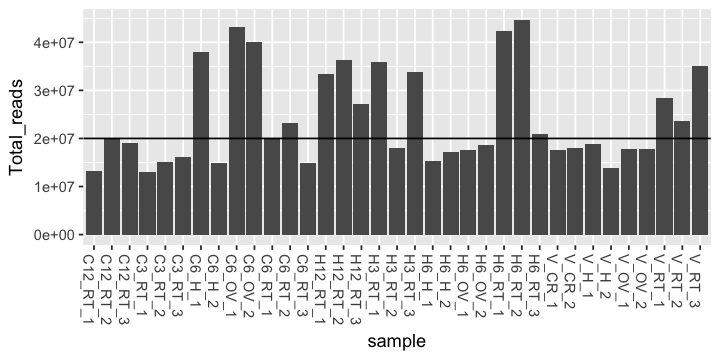

In [4]:
libSizes <- as.data.frame(colSums(DnovPM.dvir1.06.CountsMatrix))
libSizes <- cbind(sample = row.names(libSizes), libSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "Total_reads")
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(libSizes, aes(sample, Total_reads)) + 
    geom_bar(stat="identity") + 
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    geom_hline(yintercept = 20000000)

#### Boxplot of log10(TPM) across samples

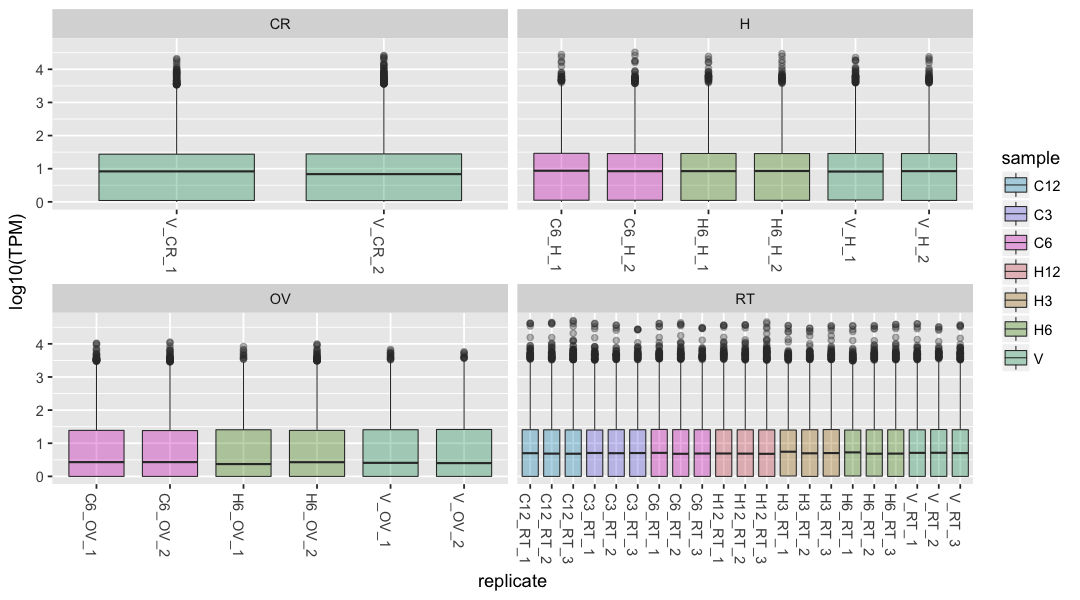

In [5]:
m.expData<-melt(as.matrix(DnovPM.dvir1.06.TmmMatrix))
colnames(m.expData) <- c("gene_id", "replicate", "TPM")
m.expData.exp<- within(m.expData, replicate<-data.frame(do.call('rbind', strsplit(as.character(replicate),'_',fixed=TRUE))))
m.expData<-data.frame(m.expData, m.expData.exp$replicate$X1, m.expData.exp$replicate$X2, m.expData.exp$replicate$X3)
colnames(m.expData) <- c("gene_id", "replicate", "TPM", "sample", "tissue", "rep_num")
m.expData$TPM <- m.expData$TPM + 1
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(m.expData) + 
    geom_boxplot(aes(x = replicate, y = log10(TPM), fill = sample), size = 0.3, alpha = I(1/3)) + 
    facet_wrap(~tissue, scales = "free_x") +
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    scale_fill_hue(l = 50, h.start = 200)

##### Estimate of the number of expressed genes (Brian Haas' method) 


Call:
lm(formula = DnovPM_filt_data[, 2] ~ DnovPM_filt_data[, 1])

Coefficients:
          (Intercept)  DnovPM_filt_data[, 1]  
               9185.3                   69.4  



Warning message:
"Removed 948 rows containing missing values (geom_point)."

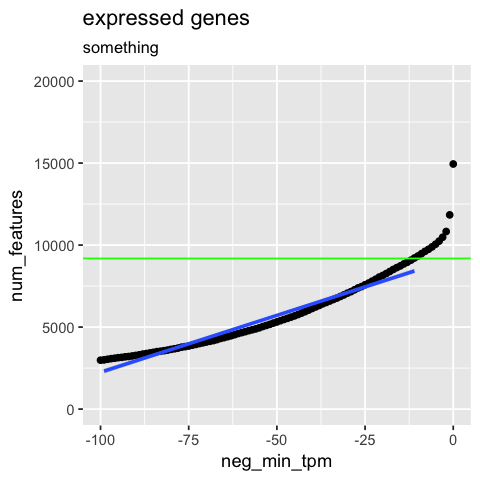

In [6]:
# extract the data between 10 TPM and 100 TPM
DnovPM_filt_data = DnovPM.dvir1.06.TpmMatrix.cbmt[DnovPM.dvir1.06.TpmMatrix.cbmt[,1] > -100 & DnovPM.dvir1.06.TpmMatrix.cbmt[,1] < -10,]
# perform a linear regression on this filtered subset of the data
DnovPM_fit = lm(DnovPM_filt_data[,2] ~ DnovPM_filt_data[,1])
print(DnovPM_fit)
# plot it
options(repr.plot.width = 4, repr.plot.height = 4)
ggplot(DnovPM.dvir1.06.TpmMatrix.cbmt, aes(neg_min_tpm,num_features)) + 
    geom_point() +  
    scale_x_continuous(limits=c(-100,0)) + 
    scale_y_continuous(limits=c(0,20000)) + 
    geom_smooth(data=DnovPM_filt_data, method = "lm") + 
    geom_hline(yintercept = 9185, colour = "green") + ggtitle("expressed genes", subtitle = "something")

#### Create DGE object

In [9]:
## calculate dispersion
d <- DGEList(counts = DnovPM.dvir1.06.CountsMatrix, group = DnovPM.Samples_data$V1)
d <- calcNormFactors(d)
d <- estimateCommonDisp(d)
d <- estimateTagwiseDisp(d)
summary(d$tagwise.dispersion)


    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.004892 0.013300 0.030820 0.180100 0.183800 2.013000 

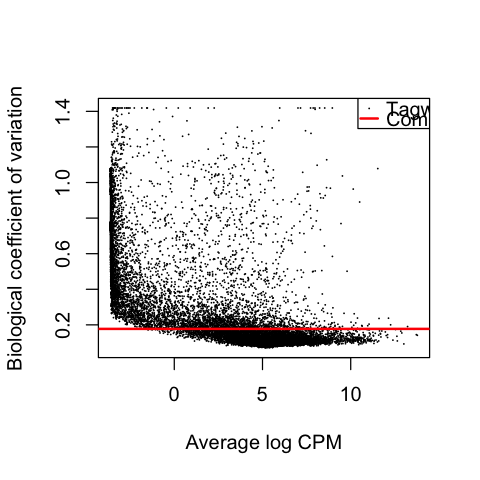

In [10]:
## Plot biological coefficient of variation
plotBCV(d)

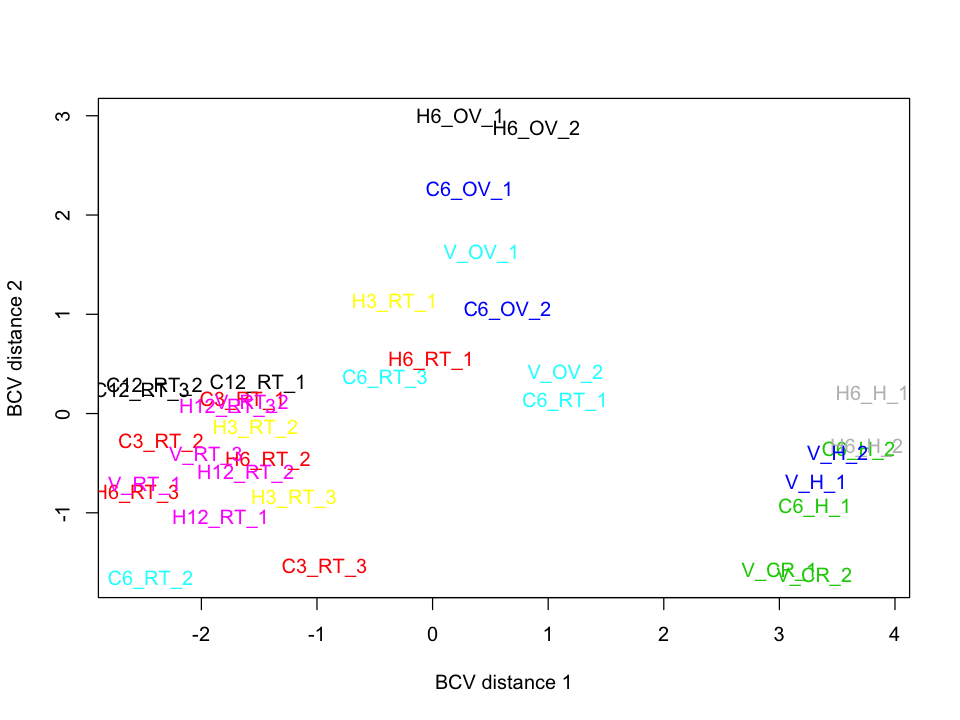

In [15]:
## Plot grouping of samples
options(repr.plot.width = 8, repr.plot.height = 6)
plotMDS(d, method = "bcv", col=as.numeric(d$samples$group))

for plotting:: min.raw: 0.735216752459159 max.raw: 1


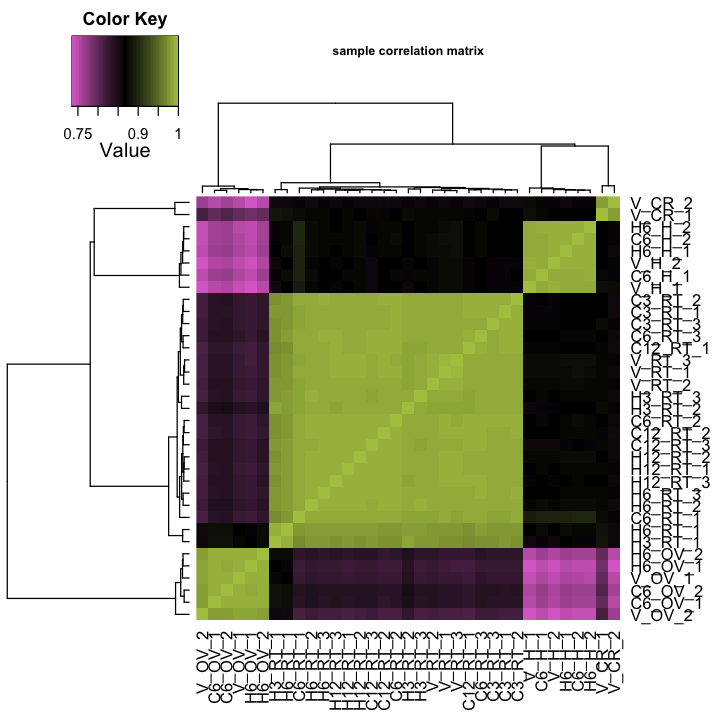

In [16]:
## Plot sample correlation
data = log2(DnovPM.dvir1.06.CountsMatrix+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 6, repr.plot.height = 6)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

Warning message:
"Removed 8 rows containing missing values (position_stack)."Warning message:
"Removed 3079 rows containing missing values (geom_point)."

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 2817 rows containing missing values (geom_point)."

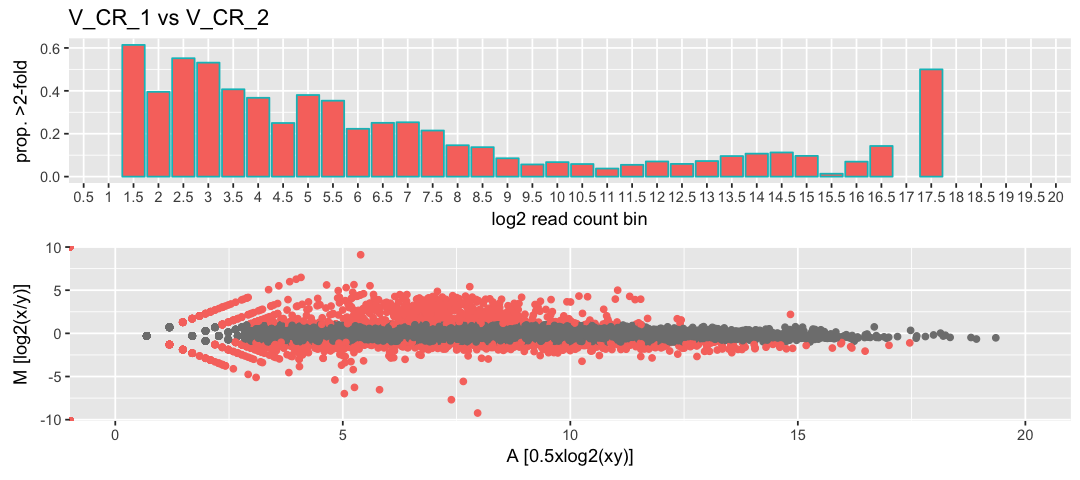

Warning message:
"Removed 16 rows containing missing values (position_stack)."Warning message:
"Removed 2724 rows containing missing values (geom_point)."

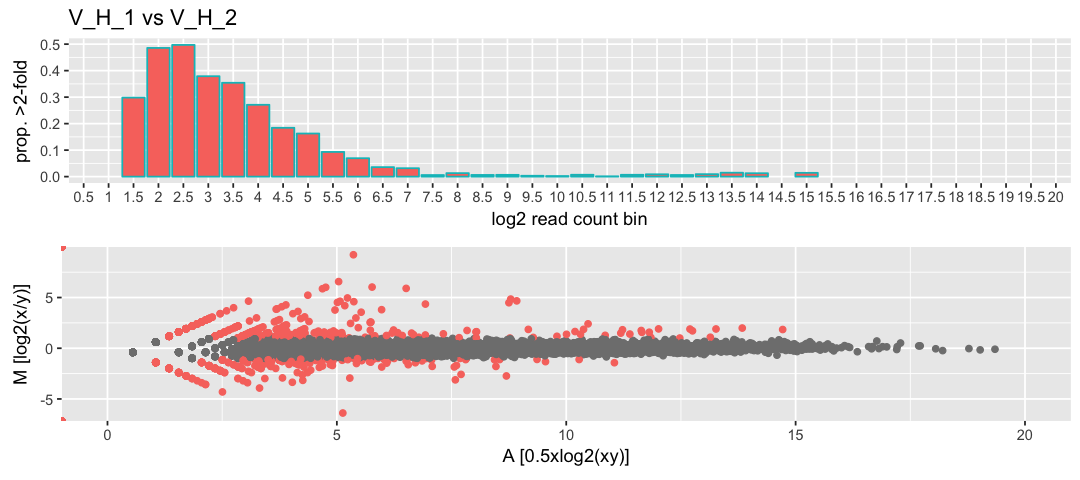

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 2843 rows containing missing values (geom_point)."

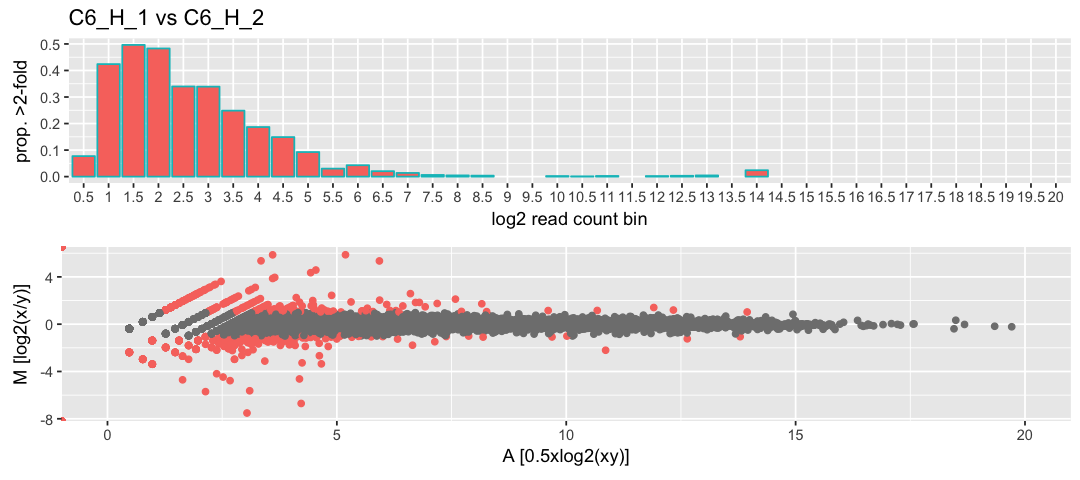

Warning message:
"Removed 10 rows containing missing values (position_stack)."Warning message:
"Removed 3977 rows containing missing values (geom_point)."

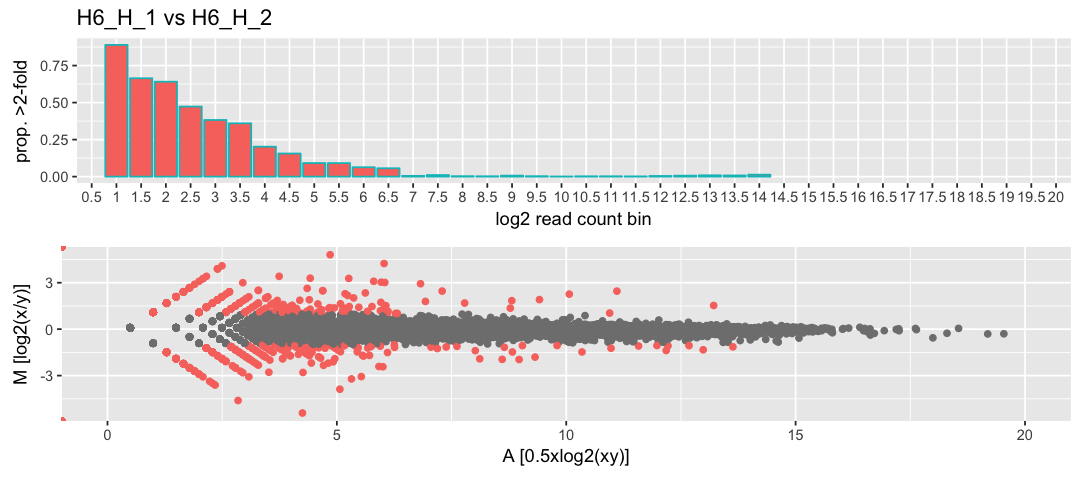

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 4060 rows containing missing values (geom_point)."

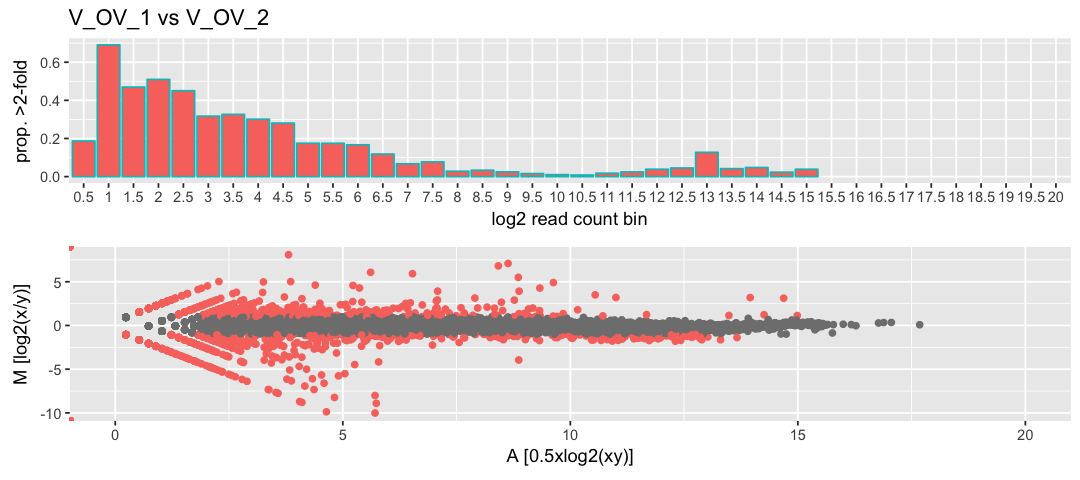

Warning message:
"Removed 14 rows containing missing values (position_stack)."Warning message:
"Removed 4152 rows containing missing values (geom_point)."

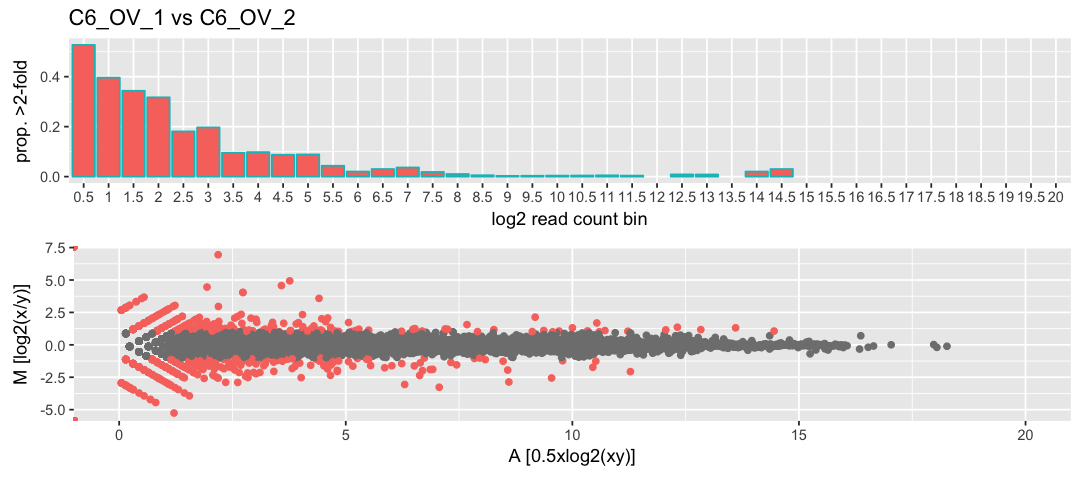

Warning message:
"Removed 15 rows containing missing values (position_stack)."Warning message:
"Removed 3598 rows containing missing values (geom_point)."

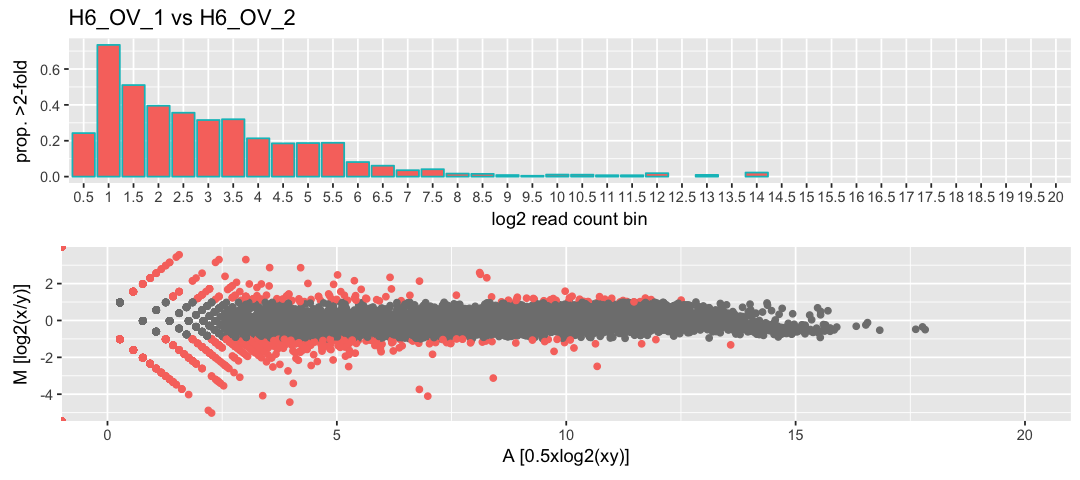

Warning message:
"Removed 14 rows containing missing values (position_stack)."Warning message:
"Removed 3629 rows containing missing values (geom_point)."

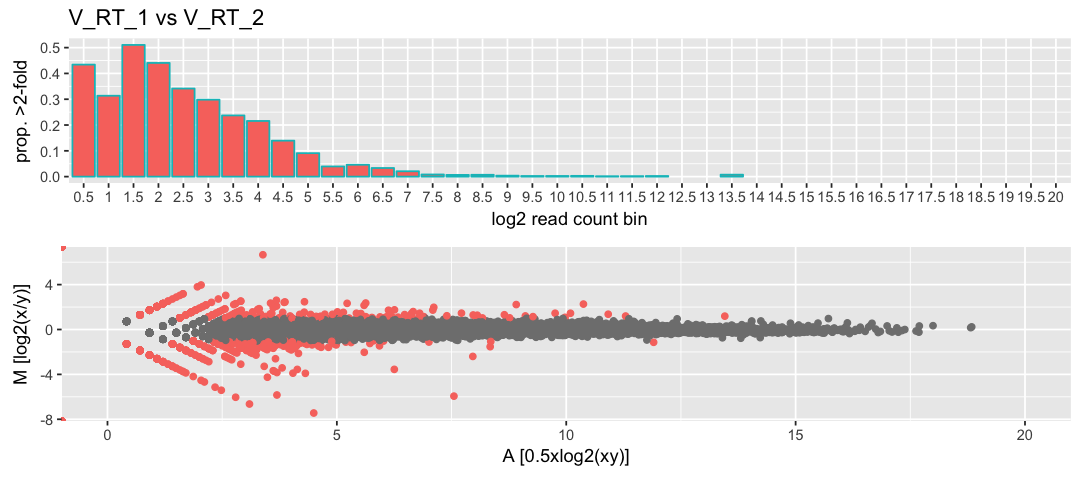

Warning message:
"Removed 17 rows containing missing values (position_stack)."Warning message:
"Removed 3525 rows containing missing values (geom_point)."

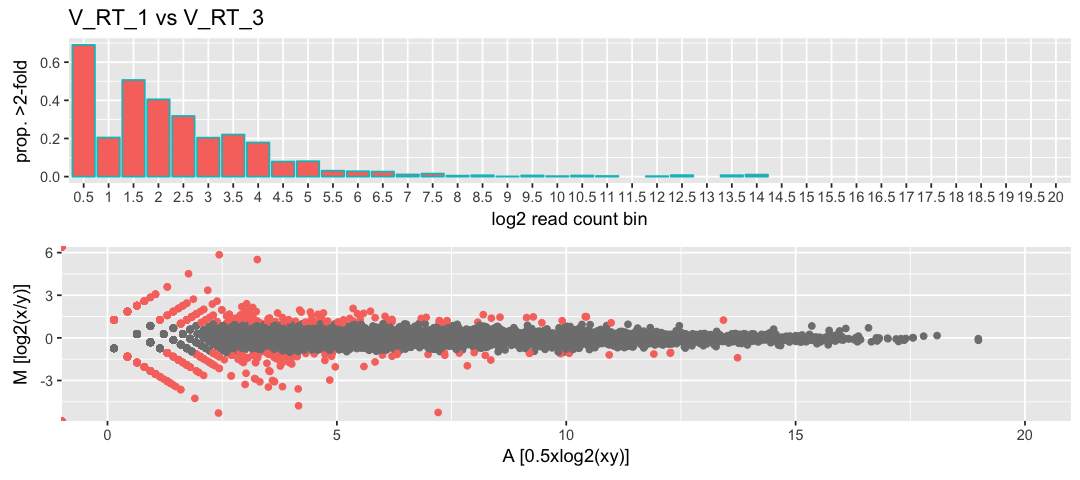

Warning message:
"Removed 14 rows containing missing values (position_stack)."Warning message:
"Removed 3812 rows containing missing values (geom_point)."

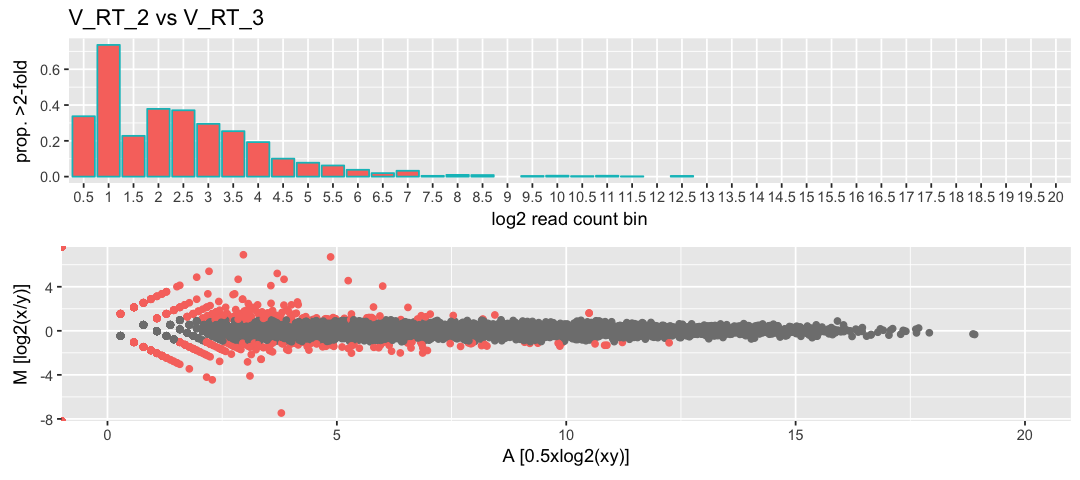

Warning message:
"Removed 18 rows containing missing values (position_stack)."Warning message:
"Removed 3716 rows containing missing values (geom_point)."

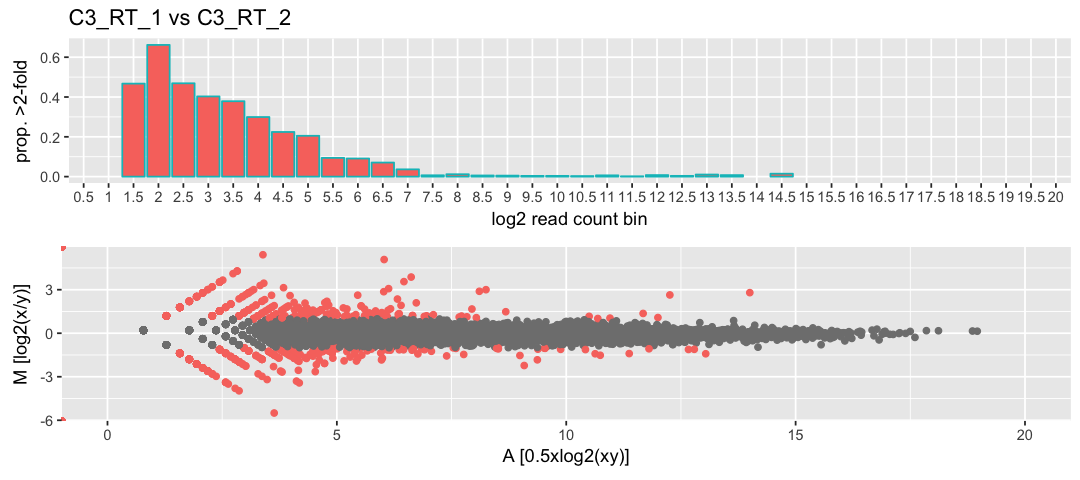

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 3704 rows containing missing values (geom_point)."

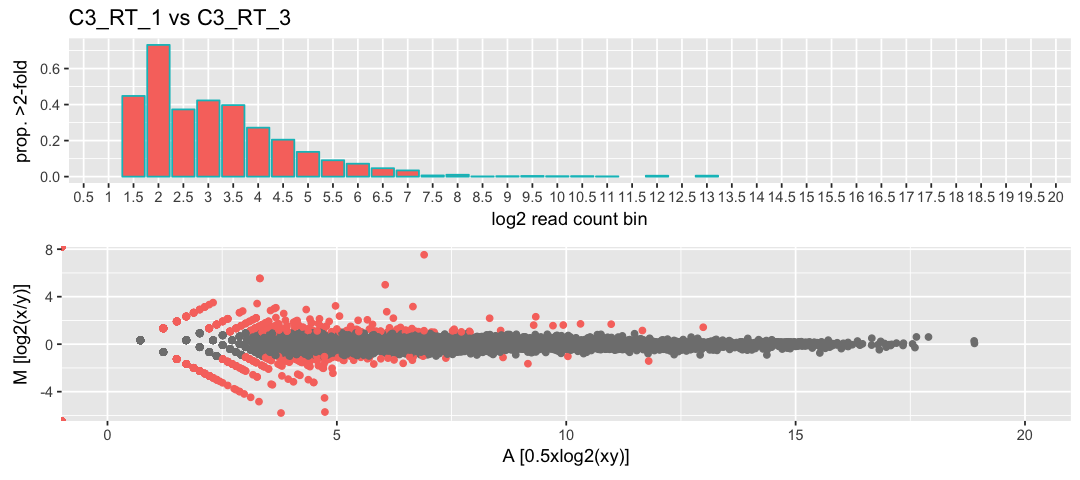

Warning message:
"Removed 19 rows containing missing values (position_stack)."Warning message:
"Removed 3468 rows containing missing values (geom_point)."

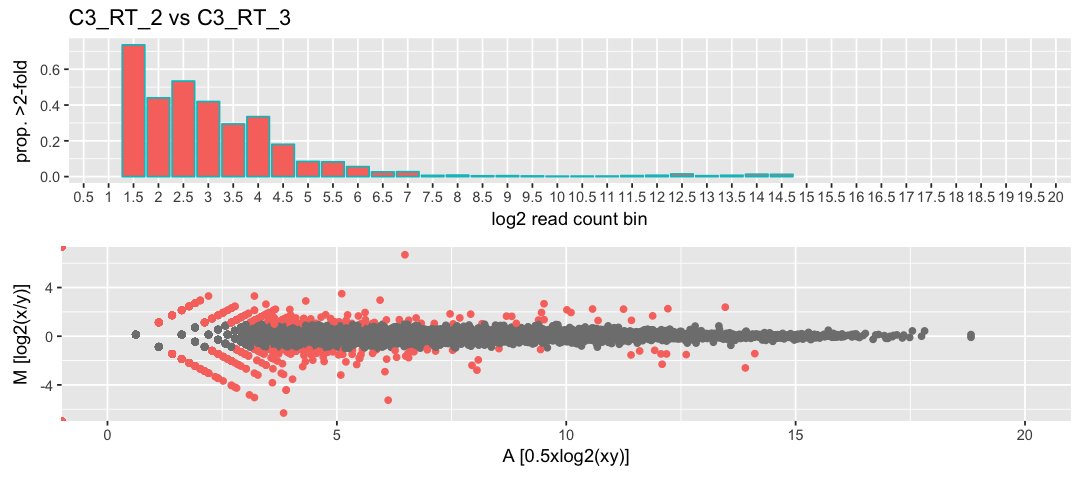

Warning message:
"Removed 19 rows containing missing values (position_stack)."Warning message:
"Removed 3468 rows containing missing values (geom_point)."

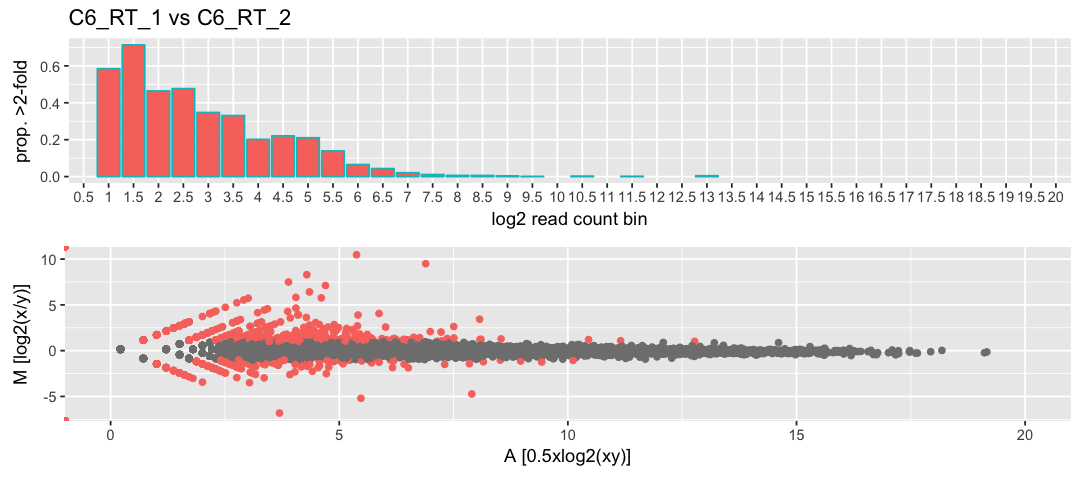

Warning message:
"Removed 13 rows containing missing values (position_stack)."Warning message:
"Removed 3692 rows containing missing values (geom_point)."

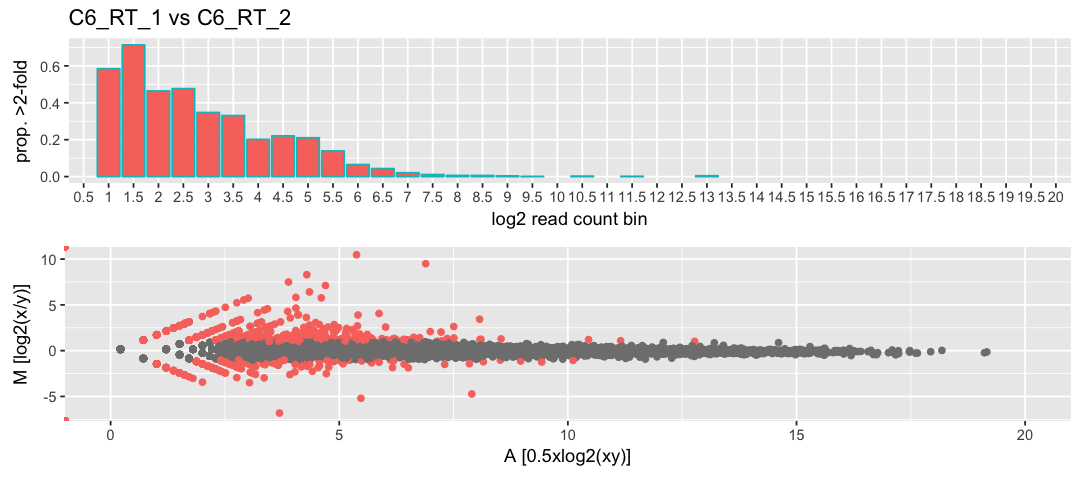

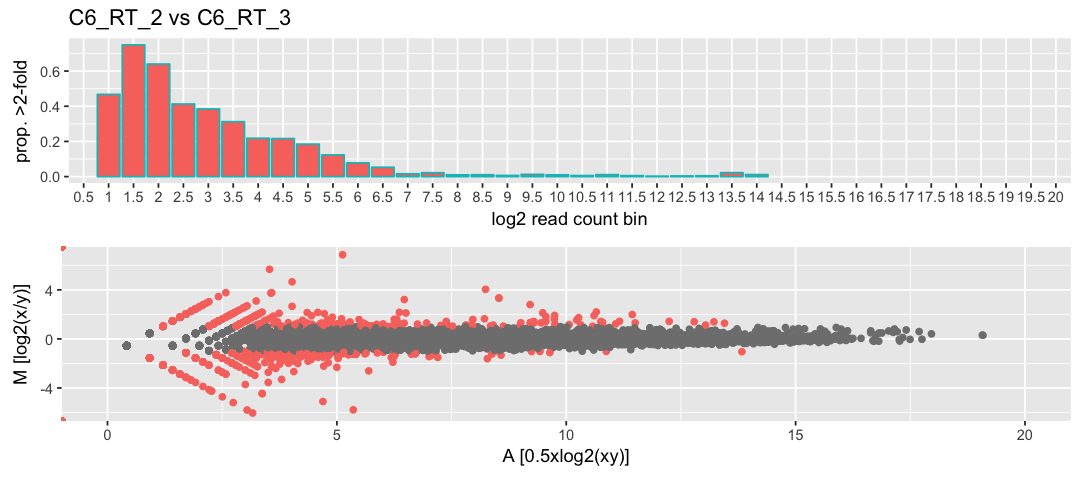

In [21]:
# normalize by DESeq method:
meta <- data.frame(row.names=colnames(DnovPM.dvir1.06.CountsMatrix), condition=DnovPM.Samples_data$V1)
DnovPMCountData<-round(DnovPM.dvir1.06.CountsMatrix)
DnovPMCountData_normByDESeq = newCountDataSet(DnovPMCountData, meta)
DnovPMCountData_normByDESeq = estimateSizeFactors(DnovPMCountData_normByDESeq)
DnovPMCountData_normByDESeq = data.frame(counts(DnovPMCountData_normByDESeq, normalized=T))

options(repr.plot.width = 9, repr.plot.height = 4)
MA_BPlot(DnovPMCountData_normByDESeq, "V_CR_1", "V_CR_2")

MA_BPlot(DnovPMCountData_normByDESeq, "V_H_1", "V_H_2")
MA_BPlot(DnovPMCountData_normByDESeq, "C6_H_1", "C6_H_2")
MA_BPlot(DnovPMCountData_normByDESeq, "H6_H_1", "H6_H_2")

MA_BPlot(DnovPMCountData_normByDESeq, "V_OV_1", "V_OV_2")
MA_BPlot(DnovPMCountData_normByDESeq, "C6_OV_1", "C6_OV_2")
MA_BPlot(DnovPMCountData_normByDESeq, "H6_OV_1", "H6_OV_2")


MA_BPlot(DnovPMCountData_normByDESeq, "V_RT_1", "V_RT_2")
MA_BPlot(DnovPMCountData_normByDESeq, "V_RT_1", "V_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "V_RT_2", "V_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "C3_RT_1", "C3_RT_2")
MA_BPlot(DnovPMCountData_normByDESeq, "C3_RT_1", "C3_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "C3_RT_2", "C3_RT_3")
MA_BPlot(DnovPMCountData_normByDESeq, "C6_RT_1", "C6_RT_2")
MA_BPlot(DnovPMCountData_normByDESeq, "C6_RT_1", "C6_RT_2")
MA_BPlot(DnovPMCountData_normByDESeq, "C6_RT_2", "C6_RT_3")

In [ ]:
DnovPM_max_gene_expr_per_row = apply(DnovPM.dvir1.06.CountsMatrix, 1, max)
DnovPM.dvir1.06.CountsMatrix.min400count = DnovPM.dvir1.06.CountsMatrix[DnovPM_max_gene_expr_per_row >= 400,,drop=F ]

##########################################################################################
################# Remove "bad" replicates  for DE analysis ###############################
### Based on the QC analysis above, some replicates show inconsistencies that are likely due to cross tissue contamination
### during dissections. The DE analysis will exclude these replicates

## Define good replicates (propper replicate grouping and correlation)
DnovPM.GoodReps = as.character(subset(DnovPM.Samples_data, V2 != "H3_RT_1" & V2 != "H6_RT_1" & V2 != "C6_RT_1")$V2)
DnovPM.GoodSamples = subset(DnovPM.Samples_data, V2 != "H3_RT_1" & V2 != "H6_RT_1" & V2 != "C6_RT_1")

## Create counts matrix with good replicates only
DnovPM.dvir1.06.CountsMatrix.BRR=subset(DnovPM.dvir1.06.CountsMatrix, select=DnovPM.GoodReps)

## Create normalized TPM matrix with good replicates only
DnovPM.dvir1.06.TmmMatrix.BRR=subset(DnovPM.dvir1.06.TmmMatrix, select=DnovPM.GoodReps)

## Rename columns to keep replicate order
# count matrices
colnames(DnovPM.dvir1.06.CountsMatrix.BRR) = DnovPM.GoodReps

# TPM matrices
colnames(DnovPM.dvir1.06.TmmMatrix.BRR) = colnames(DnovPM.dvir1.06.CountsMatrix.BRR)


#########################################################################################
### Summary TPM table and matrix for gene level plots (includes good replicates only) ######### 

DnovPM.TPM.tmp<-DnovPM.dvir1.06.TmmMatrix.BRR
colnames(DnovPM.TPM.tmp) <- DnovPM.GoodSamples$V1
m.DnovPM.TPM.tmp <- as.data.frame(melt(as.matrix(DnovPM.TPM.tmp)))
m.DnovPM.TPM.tmp <- within(m.DnovPM.TPM.tmp, X2<-data.frame(do.call('rbind', strsplit(as.character(X2),'_',fixed=TRUE))))
m.DnovPM.TPM.tmp<-data.frame(m.DnovPM.TPM.tmp$X1, m.DnovPM.TPM.tmp$X2$X1, m.DnovPM.TPM.tmp$X2$X2, m.DnovPM.TPM.tmp$value)
colnames(m.DnovPM.TPM.tmp) <- c("FBgn_ID", "sample", "tissue", "TPM")
m.DnovPM.TPM.tmp$condition <- ifelse(grepl("C", m.DnovPM.TPM.tmp$sample, ignore.case = F), "conspecific", ifelse(grepl("H", m.DnovPM.TPM.tmp$sample, ignore.case = F), "heterospecific", "virgin"))
m.DnovPM.TPM.tmp$time <- ifelse(grepl("3", m.DnovPM.TPM.tmp$sample), "3hpm", ifelse(grepl("6", m.DnovPM.TPM.tmp$sample), "6hpm", ifelse(grepl("12", m.DnovPM.TPM.tmp$sample), "12hpm","virgin")))
m.DnovPM.TPM.tmp.c = summarySE(m.DnovPM.TPM.tmp, measurevar = "TPM", groupvars = c("FBgn_ID", "sample", "tissue", "condition", "time"))
fbgn_to_geneName<-subset(gffRecord, select=c(FBgn_ID, gene_name))
TPMse_DnovPM <- merge(fbgn_to_geneName, m.DnovPM.TPM.tmp.c, all=TRUE)
DnovPM_MeanTPMmatrix<-cast(m.DnovPM.TPM.tmp.c, FBgn_ID~sample+tissue, value ="TPM")
TPMse_DnovPM$condition = factor (TPMse_DnovPM$condition, levels = c("virgin", "conspecific", "heterospecific"))
TPMse_DnovPM$time = factor (TPMse_DnovPM$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))

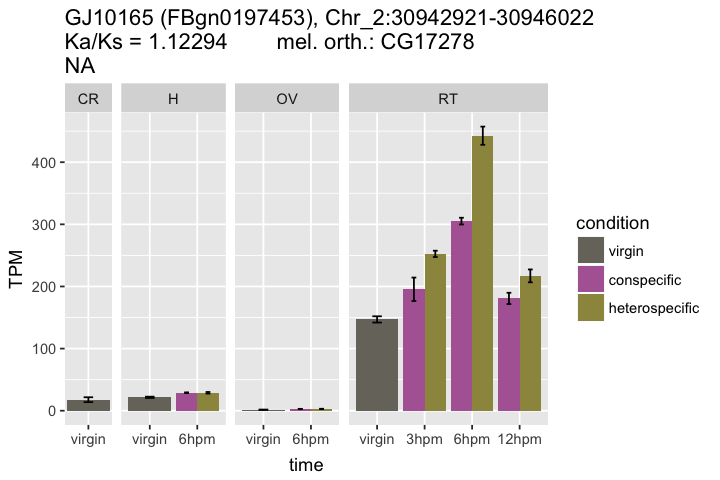

In [22]:
## plot a gene's expression like this:
options(repr.plot.width = 6, repr.plot.height = 4)

plotGenePM(TPMse_DnovPM, "GJ10165")